# Test a Raster to Point Spatial Join

## Description of Program
- program:    URSC645_00_RasterSpatialJoin
- task:       Template Jupyter Notebook File for Design Safe
- Version:    2024-03-27
- project:    URSC 645
- author:     Nathanael Rosenheim

In [1]:
import os                # for 
import sys               # for checking package versions
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import contextily as ctx

# for working with points
import geopandas as gpd

# for working with rasters
import rasterio
from rasterio.transform import from_origin
from shapely.geometry import Point
import random
from rasterstats import point_query

from pyproj import CRS, Transformer

In [2]:
print("Python Version     ", sys.version)
print("geopandas version: ", gpd.__version__)
print("pandas version:    ", pd.__version__)
print("rasterio           ", rasterio.__version__)

Python Version      3.10.13 | packaged by conda-forge | (main, Dec 23 2023, 15:27:34) [MSC v.1937 64 bit (AMD64)]
geopandas version:  0.14.3
pandas version:     2.2.0
rasterio            1.3.9


In [3]:
# Get information on current working directory (getcwd)
os.getcwd()

'g:\\Shared drives\\URSC645_S2024\\Projects\\WorkNPR'

In [4]:
# Store Program Name for output files to have the same name
programname = "URSC645_00_RasterSpatialJoin"
# Make directory to save output
if not os.path.exists(programname):
    os.mkdir(programname)

# Step 1: Obtain Data

In [5]:
# Define bounds (approximate, around Galveston)
min_x, min_y = -94.7979, 29.2413  # Adjust based on actual bounds
max_x, max_y = min_x + 0.09, min_y + 0.09  # Approx. 9km in degrees

In [6]:
# Define the projection for geographic coordinates (WGS84)
proj_4326 = CRS("epsg:4326")

# Define the projection for UTM Zone 15N
proj_26915 = CRS("epsg:26915")

# Create a transformer to convert from geographic to UTM Zone 15N
transformer = Transformer.from_crs(proj_4326, proj_26915, always_xy=True)

# Geographic coordinates for Galveston, Texas
lon, lat = min_x, max_y

# Convert geographic coordinates to UTM Zone 15N
utm_x, utm_y = transformer.transform(lon, lat)

print(f"UTM Coordinates for Zone 15N: X={utm_x}, Y={utm_y}")

UTM Coordinates for Zone 15N: X=325431.4946762203, Y=3246034.1578369476


In [7]:
# Define raster dimensions and cell size
width, height = 300, 300  # for 9km by 9km with 30m resolution
cell_size = 30

# UTM coordinates for the northwest corner of the raster (example values)
northwest_x, northwest_y = utm_x, utm_y  # Replace with actual UTM coordinates


In [8]:
# Create a gradient raster
data = np.linspace(0, 1, width * height, endpoint=False).reshape((height, width))

# Define the raster transformation
transform = from_origin(northwest_x, northwest_y, cell_size, cell_size)

# Write the raster file with UTM projection
raster_filepath = f'{programname}/{programname}_UTMraster.tif'
with rasterio.open(
    raster_filepath,
    'w', driver='GTiff',
    height=height, width=width,
    count=1, dtype=data.dtype,
    crs='EPSG:26915',
    transform=transform,
) as dst:
    dst.write(data, 1)

In [9]:
# Generate points
points = [Point(random.uniform(min_x, max_x), random.uniform(min_y, max_y)) for _ in range(100)]

# Convert to GeoDataFrame
gdf_points = gpd.GeoDataFrame(geometry=points, crs='EPSG:4326')

# Optionally, save to file
point_filepath = f'{programname}/{programname}_points.shp'
gdf_points.to_file(point_filepath)

# Step 2: Clean Data

In [10]:
# Load your raster
with rasterio.open(raster_filepath) as src:
    raster_crs = src.crs
print(f"Raster CRS: {raster_crs}")

# Assuming gdf_points is your GeoDataFrame
print(f"Points CRS: {gdf_points.crs}")

Raster CRS: EPSG:26915
Points CRS: EPSG:4326


In [11]:
# set point crs to match raster crs
gdf_points = gdf_points.to_crs(raster_crs)

In [12]:
# Perform point query to extract raster values
values = point_query(gdf_points.geometry, raster_filepath)

# Add values to GeoDataFrame
gdf_points['raster_value'] = values

print(gdf_points.head())

c:\Users\nathanael99\AppData\Local\miniconda3\envs\URSC645\lib\site-packages\rasterstats\io.py:328: NodataWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn(


                         geometry  raster_value
0  POINT (325992.377 3245223.789)      0.088576
1  POINT (327020.329 3239561.686)      0.718080
2  POINT (326308.116 3242943.976)      0.342006
3  POINT (331724.516 3243121.704)      0.324265
4  POINT (331767.498 3243032.266)      0.334218


In [13]:
# describe raster_value
gdf_points['raster_value'].describe()

count    87.000000
mean      0.504780
std       0.289665
min       0.029871
25%       0.257823
50%       0.546196
75%       0.721501
max       0.982931
Name: raster_value, dtype: float64

# Step 3: Explore Data

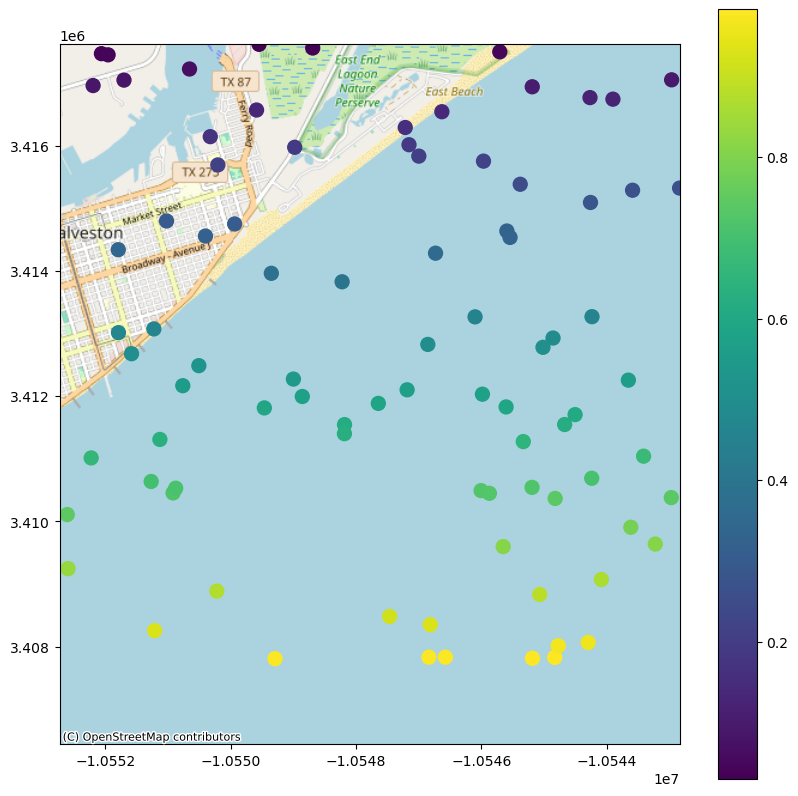

In [14]:
# Ensure your gdf_points is in the same CRS as the basemap (Web Mercator)
gdf_points_web_mercator = gdf_points.to_crs(epsg=3857)

# Plot points on top of a basemap
fig, ax = plt.subplots(figsize=(10, 10))
gdf_points_web_mercator.plot(column='raster_value', cmap='viridis', 
                             legend=True, markersize=100, ax=ax)

# Add the basemap
ctx.add_basemap(ax, source=ctx.providers.OpenStreetMap.Mapnik)

# Set the x and y limits to the bounds of your points to zoom in
ax.set_xlim(gdf_points_web_mercator.total_bounds[[0,2]])
ax.set_ylim(gdf_points_web_mercator.total_bounds[[1,3]])

plt.show()



In [15]:
# switch CRS to 4326
gdf_points = gdf_points.to_crs('EPSG:4326')

# Output files

In [16]:
# Save Work at this point as CSV
savefile = programname+"/"+programname+".csv"
gdf_points.to_csv(savefile, index=False)